# Correlation Exercise – *Galileo E1C*

After successful acquistion of GPS C/A code, this interactive notebook guides you through the Acquisition of **Galileo E1C**.

## How to work in this notebook
1. **Read the short theory sections**  They recap what the code does. Also recall the presentation slides.
2. **Open each *Task* cell (yellow bar on the left) and replace the `...` with real code or numbers.**  Run the cell *(Shift‑Enter)*.
3. **Run the script cell that follows.**  If something is still missing the script will stop and tell you what.
4. Move on to the next section.

>👉 **Tip 1:** execute the notebook **top‑to‑bottom** the first time so that all variables are visible where the scripts expect them.
>
>👉 **Tip 2:** *Click regularly on the "save to browser storage button" (next to the download button) to not lose your progress.*

# 0. IQ Data and Pre-Processing
This section demonstrates how to transform raw **I/Q** recordings into a cleaned MATLAB `.mat` file that you will load later for the actual acquisition steps.

**You will:**
1. Set the sampling frequency and file path  
2. Read the binary file, format the complex samples  
3. Inspect spectrum, time‑domain traces and amplitude histogram  
4. Save the processed vector as **`IQ_samples.mat`**

Follow the numbered code cells below and execute them in order (⇧ + ⏎).

### 1.  Set Sampling Frequency

In [1]:
% Sampling frequency (Hz)
fs = 4.092e6;  % Enter sampling frequency, e.g. 1.000e6 for 1 MHz

### 2.  Set Data File Path

In [2]:
% Path to I/Q data file
data_file = 'course_IQ_samples_E1C.dat';  % ← Enter filename, e.g. 'IQ.dat'

### 3.  Load and Format I/Q Samples
Read the binary file, handle interleaved I/Q channels, and remove initial transients.

In [3]:
% === Fixed Parameters ===
fi = 0;                   % Intermediate frequency (Hz)
IsComplex = true;         % True if data is I/Q
Is8Bits = false;          % 8-bit integer format
Is16Bits = false;         % 16-bit integer format
Is32BitsFloat = true;     % 32-bit float format
secondOfData = 1;         % Seconds of data to read
fc = 1575.42e6;          % Center frequency (Hz) for labels
% ========================

% Read binary samples
[fid, errmsg] = fopen(data_file, 'rb');     % binary read

if fid == -1
    fprintf(2, '❌  Unable to open "%s": %s\n', data_file, errmsg);
    return              % Abort this cell early
end
if IsComplex
    if Is16Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int16');
    elseif Is8Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int8');
    else
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'float32');
    end
    data = raw(1:2:end) + 1i*raw(2:2:end);
else
    if Is16Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int16');
    elseif Is8Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int8');
    else
        [data, ~] = fread(fid, secondOfData*fs, 'float32');
    end
end
fclose(fid);

% Remove initial transient samples
if length(data) > 1e6
    data(1:1e6) = [];
end

### 4.  Power Spectral Density
Use Welch's method to estimate PSD and plot it. Frequency axis is in MHz.
https://en.wikipedia.org/wiki/Welch%27s_method     <br><br>
**Questions:**<br>
What do you see? <br> 
Is the Spectrum according to your expectation?

➡️  [PSD]  Starting Welch PSD estimate …
   ✓  Loaded Octave-Forge package: signal
   ✓  PSD computed with pwelch()


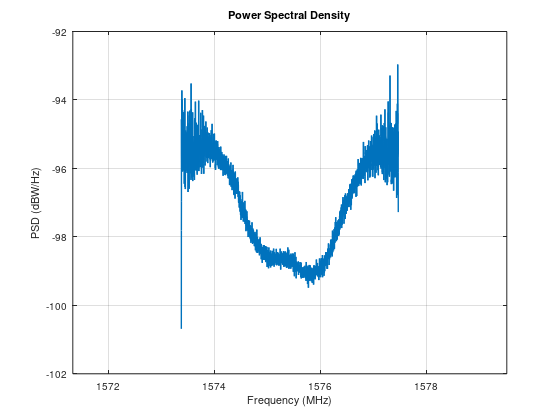

✅  [PSD]  Finished and plotted.


In [4]:
disp("➡️  [PSD]  Starting Welch PSD estimate …");

% ------------------------------------------------------------
% 1. Make sure the Octave-Forge “signal” package is available
% ------------------------------------------------------------
has_signal = false;
try
    % does "signal" appear in the installed-package list?
    pkgs = pkg("list");
    for k = 1 : numel(pkgs)
        if strcmp(pkgs{k}.name, "signal")
            has_signal = true;
            break
        end
    end
catch
    % pkg() itself not found (rare)
end

if has_signal
    try
        pkg load signal
        disp("   ✓  Loaded Octave-Forge package: signal");
    catch ME
        has_signal = false;
        fprintf(2,"   ⚠️  Could not load 'signal' package (%s). Falling back to naive PSD.\n", ME.message);
    end
else
    fprintf(2,"   ⚠️  Package 'signal' not installed. Falling back to naive PSD.\n");
end

% ------------------------------------------------------------
% 2. Compute PSD
% ------------------------------------------------------------
if has_signal
    [pw, f] = pwelch(data, [], [], [], fs);    % Welch method
    disp("   ✓  PSD computed with pwelch()");
else
    % --- simple rectangular window periodogram as a fallback ---
    Nfft  = 4096;
    win   = hanning(Nfft);                     % a little windowing to reduce leakage
    S     = fftshift( fft( data(1:Nfft) .* win.' , Nfft ) );
    pw    = (abs(S).^2) / (fs * sum(win.^2));
    f     = linspace(-fs/2, fs/2, Nfft);
    disp("   ✓  PSD computed with naive FFT method");
end

% ------------------------------------------------------------
% 3. Plot
% ------------------------------------------------------------
figure;
if IsComplex
    plot((fc+f-f(length(f))/2)/1e6, 10*log10(pw), 'LineWidth', 1);
    xlim([(fc-fs)/1e6 (fc+fs)/1e6]);
else
    plot(f/1e6,          10*log10(pw), 'LineWidth', 1);
end
grid on;
xlabel('Frequency (MHz)');
ylabel('PSD (dBW/Hz)');
title('Power Spectral Density');

disp("✅  [PSD]  Finished and plotted.");


### 5.  Time‑Domain View
Visualize the first 100,000 samples of the real and imaginary parts.

➡️  [TD]  Plotting real & imaginary parts …
   ✓  Using first 100000 samples for the snapshot.


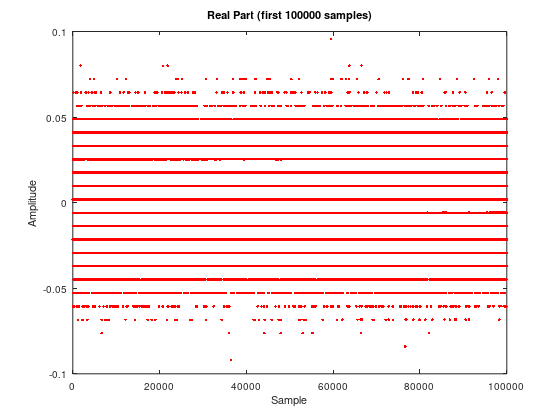

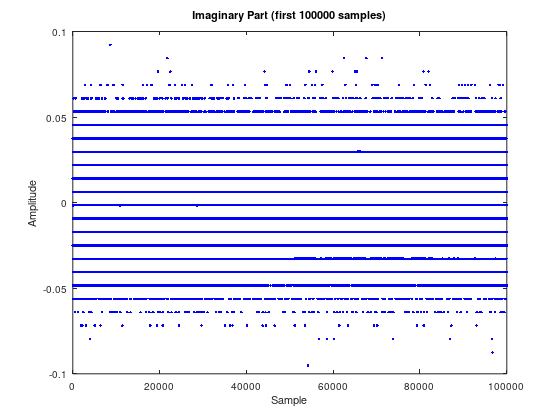

✅  [TD]  Finished plotting time-domain snapshots.


In [5]:
disp("➡️  [TD]  Plotting real & imaginary parts …");

% ------------------------------------------------------------
% 1. Decide how many samples we can safely show
% ------------------------------------------------------------
if numel(data) < 1e5
    nplot = numel(data);
    fprintf(2, "   ⚠️  Only %d samples available – plotting all of them.\n", nplot);
else
    nplot = 1e5;
    fprintf("   ✓  Using first %d samples for the snapshot.\n", nplot);
end

% ------------------------------------------------------------
% 2. Real component
% ------------------------------------------------------------
figure;
plot(real(data(1:nplot)), 'r.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Real Part (first %d samples)', nplot));

% ------------------------------------------------------------
% 3. Imaginary component
% ------------------------------------------------------------
figure;
plot(imag(data(1:nplot)), 'b.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Imaginary Part (first %d samples)', nplot));

disp("✅  [TD]  Finished plotting time-domain snapshots.");


### 6. Histogram of Real and Imaginary Component
Plot the amplitude distribution to check for clipping or quantization.

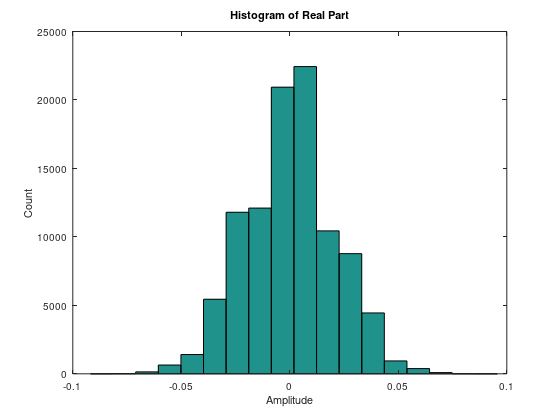

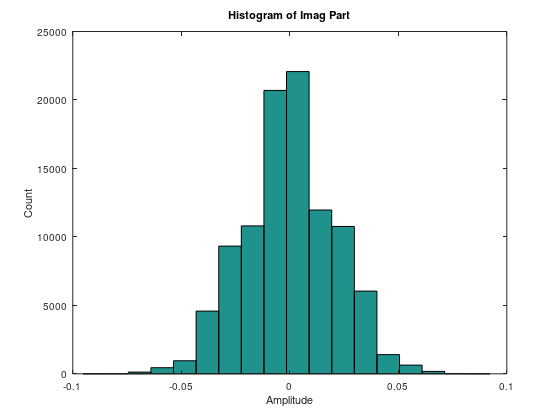

In [6]:
figure;
hist(real(data(1:1e5)), 18);
xlabel('Amplitude');
ylabel('Count');
title('Histogram of Real Part');

figure;
hist(imag(data(1:1e5)), 18);
xlabel('Amplitude');
ylabel('Count');
title('Histogram of Imag Part');

### 7.  Save Processed Data

In [7]:
% Save to MAT-file
save('IQ_samples4MHz.mat', 'data');
disp('✅ Data saved to IQ_samples.mat');
disp('✅ Check in the left sidebar, you should find the .mat file there');

✅ Data saved to IQ_samples.mat
✅ Check in the left sidebar, you should find the .mat file there


# 1. Common Helper Functions

Below are the three MATLAB/Octave functions that every GNSS acquisition routine needs.

* **`CodeAcquisition`** – builds a 2‑D delay/Doppler search space using an FFT‑based correlation technique.
* **`NoiseVarianceEstimator`** – estimate of the noise floor .
* **`InverseChiSquarePfa`** – finds the chi-square threshold (Th) such that its upper-tail probability equals the target false alarm probability (PfaT).

🔍 ***Where you still need to work*** – The first function contains *TODO* markers so you can practise the maths behind the FFT acquisition.

### ▶ **`CodeAcquisition`**
This function is extracts the signal out of the noise by performing the correlation between the collected signal samples and the replical of the GNSS signal.<br>
The function is generic and is re-used from the C/A code acquisition exercise.


In [8]:
function sspace = CodeAcquisition(signal, rep, Nc, Doppler_vec, fs, fi)
% CodeAcquisition  Evaluate the search space for code acquisition using
%                  a time-domain FFT technique
%
% Syntax:
%   sspace = CodeAcquisition(signal, rep, Nc, Doppler_vec, fs, fi)
%
% Inputs:
%   signal      [1×N]     Galileo/GPS input signal (with Doppler shift,
%                         code delay, noise, etc.)
%   rep         [1×Nc]    Local code replica
%   Nc          integer   Length of the local code replica
%   Doppler_vec [1×M]     Vector of Doppler offsets (Hz)
%   fs          scalar    Sampling frequency (Hz)
%   fi          scalar    Intermediate frequency (Hz)
%
% Output:
%   sspace      [M×N]     Search-space matrix (correlation magnitudes)

    % Normalize frequencies
    fif           = fi / fs;
    Doppler_norm  = Doppler_vec / fs;

    % TODO
    % Precompute FFT of the local replica
    F_rep = conj(fft(rep));

    % Time index vector
    N = size(signal, 2);
    t = 0:(N - 1);

    % Allocate output
    sspace = zeros(length(Doppler_norm), N);

    % Loop over all Doppler bins
    for i = 1:length(Doppler_norm)
        fc    = fif + Doppler_norm(i);
        % Mix the input down to baseband for this Doppler bin
        IQ    = exp(-2j * pi * fc .* t) .* signal;
        % FFT of the mixed signal
        X     = fft(IQ);
        % Frequency-domain correlation via multiplication
        sspace(i, :) = ifft(X .* F_rep);
    end

    % Convert to real magnitude-squared values
    sspace = real(sspace .* conj(sspace));
end

### ▶ **`NoiseVarianceEstimator`**
The function is generic and is re-used from the C/A code acquisition exercise.

In [9]:
function sigma_est = NoiseVarianceEstimator( y, fs, fc )

% Arguments:
%   y :         [vector] contains the input samples
%   fs:         [scalar] sampling frequency
%   fc:         [scalar] code rate

%
% Returns:
%   sigma_est:     [scalar] the estimated noise variance
%%

% First generate a fictitious code
clen = round( length( y ) / fs * fc );
code =  sign( rand( 1, clen ) - 0.5 );      % A bipolar random code usually has
                                            % good correlation properties

% Resample the code
loc = reshape(repmat(code,fs/fc,1),1,fs/fc*size(code,2));

% Now compute the correlators (for a single Doppler value is enough )
correlators = CodeAcquisition( y, loc, 1, 0, fs, 0 );


% Down-sample them to get uncorrelated values:
step = round( fs / fc );
correlators = correlators(1:step:end);

% Finally the noise variance estimate
sigma_est = mean( correlators );


### ▶ **`InverseChiSquarePfa`**
This routine finds the χ²–distribution threshold `Th` for `K` degrees of freedom that yields a target false‐alarm rate `PfaT`.<br>
The function is generic and is re-used from the C/A code acquisition exercise.

In [10]:
function Th = InverseChiSquarePfa( K, PfaT )

Th = -2*log( PfaT );

Niter = 1000;
Pfa = 0;
ii = 1;

fact = factorial( K - 1 );

while abs( PfaT - Pfa ) > 1e-3 * PfaT,

    Pfa = gammainc( Th / 2, K, 'upper' );					% Compute the ccdf
    pdf = exp( -Th / 2 ) .* ( Th / 2 ).^( K - 1 ) / fact;	% Compute the pdf

    Th = Th + ( Pfa - PfaT )/ pdf;

    ii = ii + 1;
    if ii > Niter,
        break;
    end
    
end

# 2. Galileo E1C acquisition

**Goal:** detect a Galileo E1C signal

Two open tasks:
1. *Task&nbsp;P1* - upsample the E1-C code to the 4.092 MHz sample rate. 
1. *Task&nbsp;P2* – generate the Binary Subcarrier Function (BOC(1,1)) at a sample rate of 4.092 MHz. One single BOC spreading symbol consists of 4 samples (sample rate is 4-times the chip-rate)
2. *Task&nbsp;P3* – Multiply element-wise (use the `.*` operator) the upsampled code (from P1) and the Binary Subcarrier (from P2) to form the replica. 


### ▶ Initialisation - Run section and use these variables for Task P1 and P2

Key aspects of this section: <br>
- load the I/Q samples stored earlier in the `.mat` file
- load E1 PRN sequences. Every Galileo satellite has a unique PRN code sequence for every signal component - note that for Galileo we do have separate Data (E1-B) and Pilot (E1-C) components <br>
  . E1-C PRN code has a length of 4092 bits - it is stored in the variable `E1C`<br>
  . E1-C modulation is BOC(1,1) - Binary Offset Carrier (BOC) modulation with a chip rate of 1 MHz and a subcarrier frequency of 1 MHz <br>
- define the coherent integration time - for Galileo it is 4 ms (duration of the PRN code)


In [11]:
%=========================================================================%
% Load the prepared IQ samples                                            %
%=========================================================================%
load IQ_samples4MHz.mat

%=========================================================================%
% Load the PRN  code                                                      %
%=========================================================================%

load E1_codes.mat;

%=========================================================================%
% Initialise                                                              %
%=========================================================================%


fi = 0;
fc = 1.023e6; % GNSS signal chip rate
fs = 4.092e6; % Sample rate
Tcoh = 4e-3; % Coherent Integration time [ms]
T_primary_code = 4e-3; %Period of the primary code [ms]
N_noncoh = 1; %Number of non-coherent accumulations
Tdwell = Tcoh *N_noncoh; %Total Dwell time [ms]
Nsample = Tcoh * fs; %Number of signal samples in Coherent Integration Period

PRN = repmat(E1C,1,round(Tcoh/T_primary_code));

### ✍️ Task P1 - *Up-sample the Galileo E1-C Code*
Build the matrix `Rep` so that each row `i` contains the up-sampled replica for PRN `i`.

**Remember:**

 - The Galileo E1-C signal is a BOC(1,1), i.e. a signal at a rate of 1.023 MHz
 
 - The recorded signal is sampled at a rate of 4.092 MHz

**What you need to do:** 

<img src="figures/BOC11_Modulation.png" width="800"/>

> *Hint: You can use the functions repmat and reshape to repeat every sample twice (1.023 → 4.092 MHz) (ref. homework)*

In [12]:
for i=1:size(PRN,1)

    Rep(i, :) = reshape(repmat(PRN(i,:) , 4, 1), 1, 4*size(PRN,2));

end

### ✍️ Task P2 - *BOC(1,1) Spreading Symbol Definition*
test

In [13]:
BOC1_1 = [1 1 -1 -1];
BOC1_1 = repmat(BOC1_1,1,round(T_primary_code*fc));
BOC1_1 = repmat(BOC1_1,size(PRN,1),1);
Rep(1,1:20)

ans,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,1,1,1,1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,-1,-1


### ✍️ Task P3 - *Multiply element wise the PRN code with the BOC(1,1) Spreading Symbol*


In [14]:
Rep = Rep.*BOC1_1;
Rep(1,1:20)

ans,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,1,-1,-1,-1,-1,1,1


In [15]:
Doppler_range = 10e3 ;
Doppler_step = round(2/(3*Tdwell));

Doppler_vec = [Doppler_step: Doppler_step: Doppler_range];
Doppler_vec = [-fliplr(Doppler_vec) 0 Doppler_vec];

### ▶ **`Acquire Galileo E1C`** *Run after tasks P1 and P2*

This function performs the acquistion of the Galileo E1-C signal, i.e. this function is
1. Testing for several Galileo E1-C codes whether the code can be acquired within the collected signal samples, i.e. whether it can be extracted out of the noise
2. Calling the `CodeAcquisition` function
3. Testing whether the energy extracted (i.e. the correlation maximum) is sufficient to declare successful acquisisition. For this decision logic with Probability of False Alarm is established.
4. In case the correlation maximum is exceeding the test threshold, acquisition is declared and you get <br>
    . Information which PRN has been acquired<br>
    . Information about Code Delay and Doppler Frequency Offset<br>
    . Plot of the Acquisition Matrix<br>
    . Acquisition Search Space results are stored in a .mat file (sspace_PRNxxx.mat)<br>

code_select = 1


code_select = 2


code_select = 3


code_select = 4


code_select = 5


code_select = 6


code_select = 7


code_select = 8


code_select = 9


code_select = 10


code_select = 11


code_select = 12


code_select = 13


code_select = 14


code_select = 15


code_select = 16


code_select = 17


code_select = 18


code_select = 19


code_select = 20


code_select = 21


code_select = 22


code_select = 23


code_select = 24


code_select = 25


code_select = 26


PRN 26 acquired, Doppler [Hz]: -668.000000, Code Delay [samples]: 6077


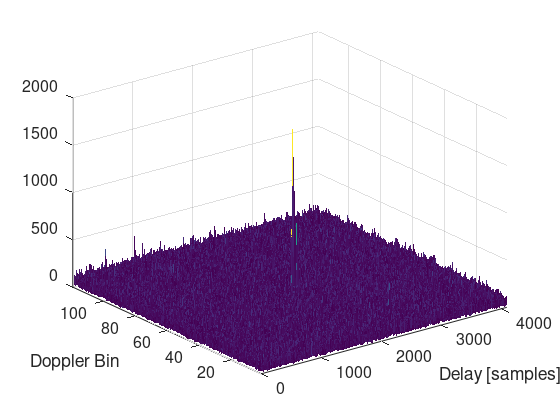

code_select = 27


code_select = 28


code_select = 29


code_select = 30


In [16]:
% Sanity checks
assert(exist('Rep','var') && exist('Doppler_vec','var'), '❌ Run Task P1/P2 first');

%=========================================================================%
% Search over all possible PRN sequences                                  %
%=========================================================================%
for code_select = 1:30
code_select
    Rep_search = Rep(code_select,:);
    
    Nc = round(Tcoh/1e-3)*fs/1e3;
    sspace = 0;
    
    for ii = 1:N_noncoh
    
        y =  data( (ii - 1) * Nc + (1:Nc) ).';   % use just 1 period of signal at the time
    
        % Compute the search space for a single coherent integration epoch
        Tsspace = CodeAcquisition( y, Rep_search, Nc, Doppler_vec, fs, fi);
        sspace = sspace + Tsspace;  % Non-coherently accumulate the results

    end

    %=========================================================================%
    % Decision Logic                                                          %
    %=========================================================================%
    Pfa_global = 0.1;
    Pfa_cell = 1-(1-Pfa_global).^(1/numel(sspace));
    
    Th = InverseChiSquarePfa(N_noncoh, Pfa_cell);
    sigma_est = NoiseVarianceEstimator(y, fs, fc);
    Th = sigma_est * Th;
    
    sspace_single_period = reshape(sspace,[size(sspace,1),fs/fc*size(PRN,2)/(Tcoh*1e3),Tcoh*1e3]);
    sspace_single_period = squeeze(sum(sspace_single_period,3));
    
    
    if (max(max(sspace)) > Th)
    
            [doppler_id, delay_id] = find(sspace == max(max(sspace)));
            fprintf('PRN %i acquired, Doppler [Hz]: %f, Code Delay [samples]: %i\n',code_select, Doppler_vec(doppler_id(1)), delay_id(1));
            figure
            surf( sspace_single_period, 'EdgeColor', 'none');
            set( gca, 'FontSize', 16)
            xlabel('Delay [samples]');
            ylabel('Doppler Bin');
            xlim([0 size(sspace_single_period,2)]);
            ylim([1 length(Doppler_vec)])
            output_file = ['sspace_PRN',num2str(code_select,'%i'),'.mat'];
            save(output_file, 'sspace', 'Doppler_vec');
    end


end

### ✍️ Task P3 - <i>Plot for your first acquired signal the Correlation Main Peak </i>

What you need to do:
1. load the `.mat` file containing the search space of a successfully acquired code (`sspace_PRNxxx.mat`)
2. Recall from above the Doppler Frequency offset
3. Find the index of the Doppler Frequency offset in the vector `Doppler_vec`
4. Plot the corresponding row of `sspace`



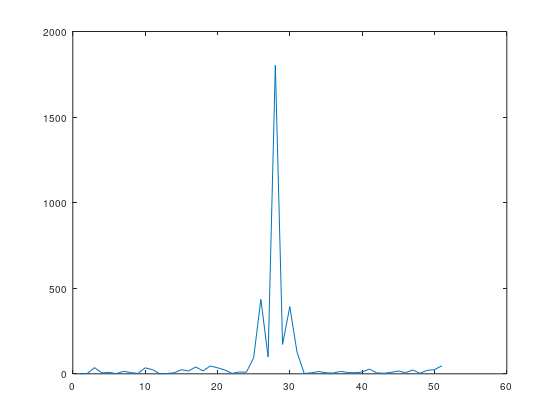

fatal: caught signal Aborted -- stopping myself...

In [19]:
load sspace_PRN26.mat
ind = find(Doppler_vec == -668);
figure; plot(sspace(ind,6050:6100))